In [33]:
import pandas as pd
from datetime import datetime

df = pd.read_csv('taxis.csv', encoding='unicode_escape')

# Question 1a
print("Question 1a")

# Split the 'pickup' column into date and time
pickup_date = df['pickup'].str.split(' ').str[0]
pickup_time = df['pickup'].str.split(' ').str[1]

# Split the 'dropoff' column into date and time
dropoff_date = df['dropoff'].str.split(' ').str[0]
dropoff_time = df['dropoff'].str.split(' ').str[1]

# Insert these new columns to the leftmost side of the dataframe
df.insert(0, 'pickup_date', pickup_date)
df.insert(1, 'pickup_time', pickup_time)
df.insert(2, 'dropoff_date', dropoff_date)
df.insert(3, 'dropoff_time', dropoff_time)


# Print top 5 rows, dropping pickup and dropoff temporarily
print("After spliting the date and time for pick and dropoff, here's the resultant df:\n")
print(df.drop(columns=['pickup', 'dropoff']).head(5).to_string(header=True, index=False, col_space=10))

Question 1a
After spliting the date and time for pick and dropoff, here's the resultant df:

pickup_date pickup_time dropoff_date dropoff_time  passengers   distance       fare        tip      tolls      total      color     payment           pickup_zone          dropoff_zone pickup_borough dropoff_borough
 2019-03-23    20:21:09   2019-03-23     20:27:24           1       1.60        7.0       2.15        0.0      12.95     yellow credit card       Lenox Hill West   UN/Turtle Bay South      Manhattan       Manhattan
 2019-03-04    16:11:55   2019-03-04     16:19:00           1       0.79        5.0       0.00        0.0       9.30     yellow        cash Upper West Side South Upper West Side South      Manhattan       Manhattan
 2019-03-27    17:53:01   2019-03-27     18:00:25           1       1.37        7.5       2.36        0.0      14.16     yellow credit card         Alphabet City          West Village      Manhattan       Manhattan
 2019-03-10    01:23:59   2019-03-10     01:49:

In [35]:
# Question 1b - compute for the green and yellow
print("Question 1b")
# Convert pickup_time and dropoff_time to datetime
df['pickup_time'] = pd.to_datetime(df['pickup_time'], format='%H:%M:%S')
df['dropoff_time'] = pd.to_datetime(df['dropoff_time'], format='%H:%M:%S')

# Calculate the time of travel for each row and add it as a new column
df['travel_time'] = (df['dropoff_time'] - df['pickup_time']).dt.total_seconds() / 60  # This gives travel time in minutes

# convert back to time
df['pickup_time'] = pd.to_datetime(df['pickup_time'], format='%H:%M:%S').dt.time
df['dropoff_time'] = pd.to_datetime(df['dropoff_time'], format='%H:%M:%S').dt.time

# Group by car_type and compute the totals
color_agg_results = df.groupby('color').agg({
    'fare': 'sum',
    'passengers': 'sum',
    'distance': 'sum',
    'travel_time': 'sum'
})

# Convert the total travel time from minutes to "Days Hours:Minutes:Seconds"
color_agg_results['travel_time'] = pd.to_timedelta(color_agg_results['travel_time'], unit='s')
color_agg_results['travel_time'] = color_agg_results['travel_time'].astype(str)

print("The aggregated results of fare, passengers, distance and travel_time for each colour is:")
print(color_agg_results.to_string(header=True, index=False, col_space=10))


Question 1b
The aggregated results of fare, passengers, distance and travel_time for each colour is:
      fare  passengers   distance               travel_time
  13788.15        1226    3345.95 0 days 03:03:37.766666667
  70426.72        8676   16111.41 0 days 02:34:53.316666667


In [36]:
# Question 2
print("Question 2")
# Filter for cash payments and specific pickup dates
cash_df = df[(df['payment'] == 'cash') & pd.to_datetime(df['pickup_date']).dt.day.isin([10, 15, 20, 25, 30])]
# print(cash_df)

# Function to get row with max distance for each group
def get_max_distance_trip(group):
    idx = group['distance'].idxmax() 
    if pd.notna(idx):  # checks if idx is not NaN
        return group.loc[idx]
    else:
        return pd.Series({'distance': 0})

# Group by car color and pickup date, then apply the function
max_distance_df = cash_df.groupby(['color', 'pickup_date']).apply(get_max_distance_trip)

# Filter and rearrange columns
GY_cash = max_distance_df[['color', 'distance', 'pickup', 'pickup_date', 'pickup_time', 'dropoff', 'dropoff_date', 'dropoff_time', 'fare']]
GY_cash.columns = ['color', 'distance', 'pickup', 'pickup_date', 'pickup_time', 'dropoff', 'dropoff_date', 'dropoff_time', 'fare']

GY_cash = GY_cash.reset_index(drop=True)

print(GY_cash.to_string(header=True, index=False, col_space=10))

Question 2
     color   distance              pickup pickup_date pickup_time             dropoff dropoff_date dropoff_time       fare
     green      16.01 2019-03-10 00:59:49  2019-03-10    00:59:49 2019-03-10 01:36:25   2019-03-10     01:36:25       47.0
     green       4.71 2019-03-15 06:42:17  2019-03-15    06:42:17 2019-03-15 06:54:38   2019-03-15     06:54:38       15.0
     green       6.66 2019-03-20 12:04:33  2019-03-20    12:04:33 2019-03-20 12:28:07   2019-03-20     12:28:07       20.0
     green       8.80 2019-03-25 10:10:11  2019-03-25    10:10:11 2019-03-25 10:46:25   2019-03-25     10:46:25       31.0
     green      10.32 2019-03-30 09:25:32  2019-03-30    09:25:32 2019-03-30 09:54:33   2019-03-30     09:54:33       31.0
    yellow      11.52 2019-03-10 00:13:12  2019-03-10    00:13:12 2019-03-10 00:33:09   2019-03-10     00:33:09       32.5
    yellow      15.64 2019-03-15 16:45:55  2019-03-15    16:45:55 2019-03-15 17:46:47   2019-03-15     17:46:47       50.0
    y

In [37]:
# Question 3
print("Question 3")

# Group by 'pickup_date' and find the index with the maximum 'distance'
idx = GY_cash.groupby('pickup_date')['distance'].idxmax()

# Create a new dataframe with only the rows with the maximum 'distance' for each 'pickup_date'
GY_maxDist = GY_cash.loc[idx]

# Display the new DataFrame
print(GY_maxDist.to_string(header=True, index=False, col_space=10))

Question 3
     color   distance              pickup pickup_date pickup_time             dropoff dropoff_date dropoff_time       fare
     green      16.01 2019-03-10 00:59:49  2019-03-10    00:59:49 2019-03-10 01:36:25   2019-03-10     01:36:25       47.0
    yellow      15.64 2019-03-15 16:45:55  2019-03-15    16:45:55 2019-03-15 17:46:47   2019-03-15     17:46:47       50.0
    yellow      17.01 2019-03-20 17:22:33  2019-03-20    17:22:33 2019-03-20 18:07:19   2019-03-20     18:07:19       52.0
    yellow      12.12 2019-03-25 05:33:43  2019-03-25    05:33:43 2019-03-25 05:58:38   2019-03-25     05:58:38       35.5
    yellow      17.14 2019-03-30 14:56:08  2019-03-30    14:56:08 2019-03-30 15:49:32   2019-03-30     15:49:32       52.0


In [38]:
# Question 4
print("Question 4")

# Function to calculate speed
def calculate_speed(row):
    # Convert date and time columns to datetime objects
    pickup_datetime = pd.to_datetime(row['pickup_date'] + ' ' + row['pickup_time'].strftime('%H:%M:%S'))
    dropoff_datetime = pd.to_datetime(row['dropoff_date'] + ' ' + row['dropoff_time'].strftime('%H:%M:%S'))
    
    # Convert distance from kilometers to meters
    distance_m = row['distance'] * 1000
    
    # Calculate time difference in seconds
    time_difference = (dropoff_datetime - pickup_datetime).total_seconds()
    
    # Handle cases where time_difference is zero to avoid division by zero error
    if time_difference == 0:
        return 0
    
    # Calculate speed in meters per second
    speed = distance_m / time_difference
    
    return speed

# Applying the function to calculate speed
GY_maxDist['speed'] = GY_maxDist.apply(calculate_speed, axis=1)

# Display the updated DataFrame
print(GY_maxDist)


Question 4
    color  distance               pickup pickup_date pickup_time  \
0   green     16.01  2019-03-10 00:59:49  2019-03-10    00:59:49   
6  yellow     15.64  2019-03-15 16:45:55  2019-03-15    16:45:55   
7  yellow     17.01  2019-03-20 17:22:33  2019-03-20    17:22:33   
8  yellow     12.12  2019-03-25 05:33:43  2019-03-25    05:33:43   
9  yellow     17.14  2019-03-30 14:56:08  2019-03-30    14:56:08   

               dropoff dropoff_date dropoff_time  fare     speed  
0  2019-03-10 01:36:25   2019-03-10     01:36:25  47.0  7.290528  
6  2019-03-15 17:46:47   2019-03-15     17:46:47  50.0  4.282585  
7  2019-03-20 18:07:19   2019-03-20     18:07:19  52.0  6.332837  
8  2019-03-25 05:58:38   2019-03-25     05:58:38  35.5  8.107023  
9  2019-03-30 15:49:32   2019-03-30     15:49:32  52.0  5.349563  


In [49]:
# Question 5
print("Question 5")

# Convert 'pickup_date' to datetime objects
df['pickup_date'] = pd.to_datetime(df['pickup_date'])

# Filter the dataset for the specified conditions
filtered_df = df[
    (df['pickup_borough'] == 'Brooklyn') & 
    (df['dropoff_borough'] == 'Manhattan') & 
    (df['pickup_date'] >= '2019-03-10') & 
    (df['pickup_date'] <= '2019-03-25')
]

filtered_df = filtered_df.copy()  # Create a new copy to avoid SettingWithCopyWarning

# Create datetime objects for 'pickup_time' and 'dropoff_time'
filtered_df['pickup_datetime'] = pd.to_datetime(filtered_df['pickup_date'].astype(str) + ' ' + filtered_df['pickup_time'].astype(str))
filtered_df['dropoff_datetime'] = pd.to_datetime(filtered_df['dropoff_date'].astype(str) + ' ' + filtered_df['dropoff_time'].astype(str))

# Compute the actual speed for each trip
def calculate_speed(row):
    distance_m = row['distance'] * 1000  # Convert distance from kilometers to meters
    time_difference = (row['dropoff_datetime'] - row['pickup_datetime']).total_seconds()
    if time_difference == 0:
        return 0
    speed = distance_m / time_difference
    return speed

filtered_df['speed'] = filtered_df.apply(calculate_speed, axis=1)

# Calculate the mean speed for green and yellow cars
mean_speeds = filtered_df.groupby('color')['speed'].mean()

# Print the results
print(mean_speeds)


Question 5
color
green     3.357360
yellow    4.203138
Name: speed, dtype: float64


In [52]:
# Question 6
print("Question 6")

# Convert 'pickup_date' to datetime type and 'pickup_time' to time type
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df['pickup_time'] = pd.to_datetime(df['pickup_time'], format='%H:%M:%S').dt.time

# Define the start and end time
start_time = pd.to_datetime('14:30:00', format='%H:%M:%S').time()
end_time = pd.to_datetime('16:00:00', format='%H:%M:%S').time()

# Filter the dataframe for the specified date and time range
filtered_df = df[
    (df['pickup_date'].dt.date == pd.to_datetime('2019-03-17').date()) & 
    (df['pickup_time'] >= start_time) & 
    (df['pickup_time'] <= end_time)
]

# Group by 'color' and count the number of pickups for each color
color_pickup_counts = filtered_df.groupby('color')['pickup_time'].count()

# Find the color with the maximum number of pickups
most_pickups_color = color_pickup_counts.idxmax()

print(f"The color with the most pickups between 2:30 pm and 4:00 pm on March 17th was: {most_pickups_color}")


Question 6
The color with the most pickups between 2:30 pm and 4:00 pm on March 17th was: yellow


In [66]:
# Question 7
print("Question 7")

df2 = pd.read_csv('taxis.csv')

# Group the data by pickup zone and calculate the required statistics
# https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html
result_df = df.groupby('pickup_zone').agg(
    min_passengers=('passengers', 'min'),
    max_passengers=('passengers', 'max'),
    total_passengers=('passengers', 'sum'),
    min_fare=('fare', 'min'),
    max_fare=('fare', 'max'),
    total_fare=('fare', 'sum'),
)

# Reorganize the columns to have a multi-level index
# https://pandas.pydata.org/docs/reference/api/pandas.MultiIndex.from_tuples.html
result_df.columns = pd.MultiIndex.from_tuples(
    [
        ('', 'min'),
        ('passengers', 'max'),
        ('passengers', 'total'),
        ('', 'min'),
        ('fare', 'max'),
        ('fare', 'total'),
    ],
    names=[None, None]
)

# Display the first 5 rows of the resulting dataframe
print(result_df.head().to_string(header=True, index=True, col_space=10))



Question 7
                                   passengers                             fare           
                               min        max      total        min        max      total
pickup_zone                                                                              
Allerton/Pelham Gardens          1          1          2       10.5      54.16      64.66
Alphabet City                    1          2         11        5.0      28.50     107.50
Astoria                          1          6        102        2.5      36.50     514.50
Auburndale                       1          1          1       21.4      21.40      21.40
Battery Park                     6          6          6       19.0      19.00      19.00


In [72]:
# Question 8
# TODO: Troubleshoot the issue of using df instead of df3 - resulting in higher distance calculated
print("Question 8")

df3 = pd.read_csv('taxis.csv')

# SCnvert distance from miles to kms (1 mile = 1.60934 kms)
df3['distance'] = df3['distance'] * 1.60934

# Calculate fuel cost
df3['fuel_cost'] = (df3['distance'] * 5.5 / 100) * 3

# Group the data by color, pickup zone and calculate the required statistics
# https://pandas.pydata.org/pandas-docs/dev/reference/api/pandas.NamedAgg.html
stats_q8 = df3.groupby(['color', 'pickup_zone']).agg(
    num_trips=pd.NamedAgg(column='pickup', aggfunc='count'),
    total_passengers=pd.NamedAgg(column='passengers', aggfunc='sum'),
    total_distance=pd.NamedAgg(column='distance', aggfunc='sum'),
    total_fare=pd.NamedAgg(column='fare', aggfunc='sum'),
    total_fuel_cost=pd.NamedAgg(column='fuel_cost', aggfunc='sum'),
)

# Split the data into two separate DataFrames based on the color
Yellow_stats_df = stats_q8.loc['yellow'].reset_index()
Green_stats_df = stats_q8.loc['green'].reset_index()

# Display the top 5 rows of each DataFrame
print("From the color yellow:")
print(Yellow_stats_df.head())
print("\nFrom the color green:")
print(Green_stats_df.head())


Question 8
From the color yellow:
         pickup_zone  num_trips  total_passengers  total_distance  total_fare  \
0      Alphabet City          9                11       40.507088       107.5   
1            Astoria         13                18       37.626369       109.0   
2       Battery Park          1                 6        8.674343        19.0   
3  Battery Park City         43                59      280.282654       681.5   
4            Bedford          1                 1        9.334172        22.0   

   total_fuel_cost  
0         6.683669  
1         6.208351  
2         1.431267  
3        46.246638  
4         1.540138  

From the color green:
               pickup_zone  num_trips  total_passengers  total_distance  \
0  Allerton/Pelham Gardens          2                 2       37.159661   
1                  Astoria         52                84      131.145117   
2               Auburndale          1                 1       10.122749   
3                Bay Ridge    

In [85]:
# Question 9
print("Question 9")

# Compute the total stats for yellow cabs
yellow_total_passengers = Yellow_stats_df['total_passengers'].sum()
yellow_total_distance = Yellow_stats_df['total_distance'].sum()
yellow_total_fare = Yellow_stats_df['total_fare'].sum()
yellow_total_fuel_cost = Yellow_stats_df['total_fuel_cost'].sum()

# Compute the total stats for green cabs
green_total_passengers = Green_stats_df['total_passengers'].sum()
green_total_distance = Green_stats_df['total_distance'].sum()
green_total_fare = Green_stats_df['total_fare'].sum()
green_total_fuel_cost = Green_stats_df['total_fuel_cost'].sum()

# Print the results
print("Yellow cabs:")
print(f"Total number of passengers travelled: {yellow_total_passengers}")
print(f"Total distance travelled: {yellow_total_distance:.2f} kms")
print(f"Total fare: ${yellow_total_fare:.2f}")
print(f"Total fuel cost: ${yellow_total_fuel_cost:.2f}")

print("\nGreen cabs:")
print(f"Total number of passengers travelled: {green_total_passengers}")
print(f"Total distance travelled: {green_total_distance:.2f} kms")
print(f"Total fare: ${green_total_fare:.2f}")
print(f"Total fuel cost: ${green_total_fuel_cost:.2f}")

# dataframe format: 
data = {
    'Cab_Color': ['Yellow', 'Green'],
    'Total_Passengers': [yellow_total_passengers, green_total_passengers],
    'Total_Distance(km)': [yellow_total_distance, green_total_distance],
    'Total_Fare($)': [yellow_total_fare, green_total_fare],
    'Total_Fuel_Cost($)': [yellow_total_fuel_cost, green_total_fuel_cost]
}

# Convert the dictionary into a DataFrame
total_stats_df = pd.DataFrame(data)

# Display the new DataFrame
print(total_stats_df)

# TODO: Solve the discrepancy between the 2 results - which may be caused by null values, aggregated data generated directly from df3

# # Create aggregated data
# agg_data = df3.groupby('color').agg(
#     total_passengers=pd.NamedAgg(column='passengers', aggfunc='sum'),
#     total_distance=pd.NamedAgg(column='distance', aggfunc='sum'),
#     total_fare=pd.NamedAgg(column='fare', aggfunc='sum'),
#     total_fuel_cost=pd.NamedAgg(column='fuel_cost', aggfunc='sum'),
# ).reset_index()

# # Display the new DataFrame
# print(agg_data)


Question 9
Yellow cabs:
Total number of passengers travelled: 8649
Total distance travelled: 25844.02 kms
Total fare: $69781.22
Total fuel cost: $4264.26

Green cabs:
Total number of passengers travelled: 1222
Total distance travelled: 5384.77 kms
Total fare: $13760.65
Total fuel cost: $888.49
  Cab_Color  Total_Passengers  Total_Distance(km)  Total_Fare($)  \
0    Yellow              8649        25844.020912       69781.22   
1     Green              1222         5384.771173       13760.65   

   Total_Fuel_Cost($)  
0         4264.263450  
1          888.487244  


In [96]:
# Question 10a
print("Question 10a")

# Sort the pickup zones by total fare in descending order and get the top 10 zones for yellow cabs
top10_yellow_pickup_zones = Yellow_stats_df.sort_values(by='total_fare', ascending=False).head(10)

# Reset the index to start from 1 instead of 0
top10_yellow_pickup_zones.reset_index(drop=True, inplace=True)
top10_yellow_pickup_zones.index += 1

# Sort the pickup zones by total fare in descending order and get the top 10 zones for green cabs
top10_green_pickup_zones = Green_stats_df.sort_values(by='total_fare', ascending=False).head(10)

# Reset the index to start from 1 instead of 0
top10_green_pickup_zones.reset_index(drop=True, inplace=True)
top10_green_pickup_zones.index += 1

# Display the top 10 pickup zones for yellow and green cabs
print("Top 10 pickup zones for yellow cabs:")
print(top10_yellow_pickup_zones)

print("\nTop 10 pickup zones for green cabs:")
print(top10_green_pickup_zones)


Question 10a
Top 10 pickup zones for yellow cabs:
                     pickup_zone  num_trips  total_passengers  total_distance  \
1                    JFK Airport        151               240     3668.152569   
2              LaGuardia Airport        146               246     2177.485300   
3                 Midtown Center        230               362      961.693304   
4   Penn Station/Madison Sq West        210               324      743.321959   
5      Times Sq/Theatre District        184               317      796.896888   
6                   Clinton East        208               330      691.613865   
7                   Midtown East        198               327      713.710103   
8            Lincoln Square East        177               240      676.180294   
9                       Union Sq        180               280      638.280337   
10         Upper East Side South        211               328      554.675124   

    total_fare  total_fuel_cost  
1      6713.06       605

Question 10b
Bar Graph for Yellow Cars:


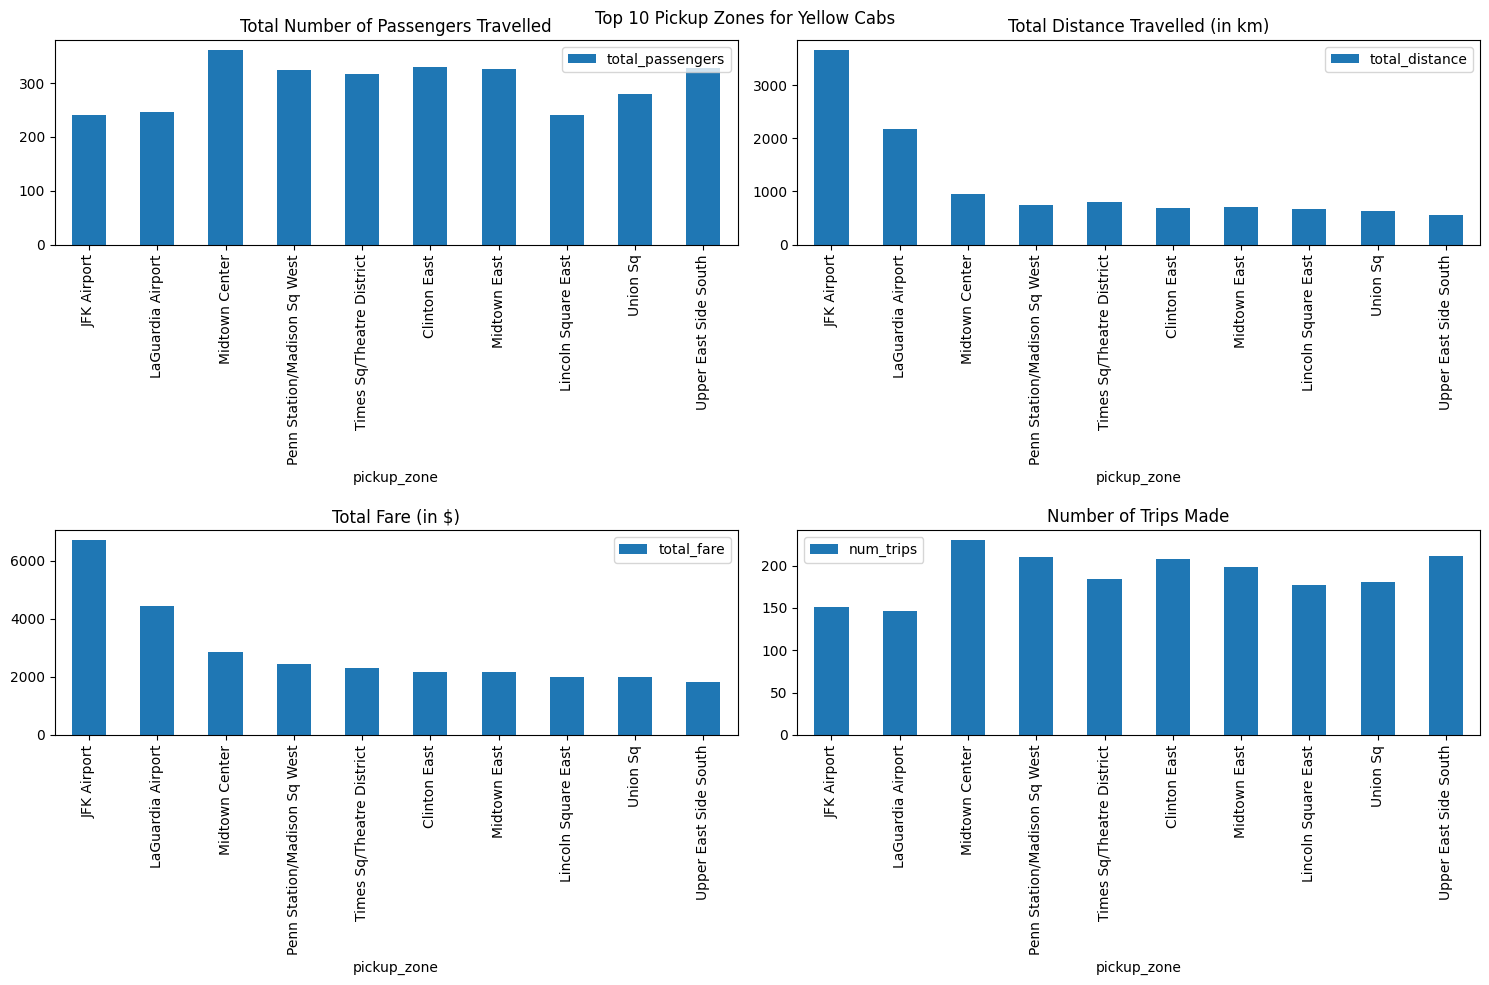

Bar Graph for Green Cars:


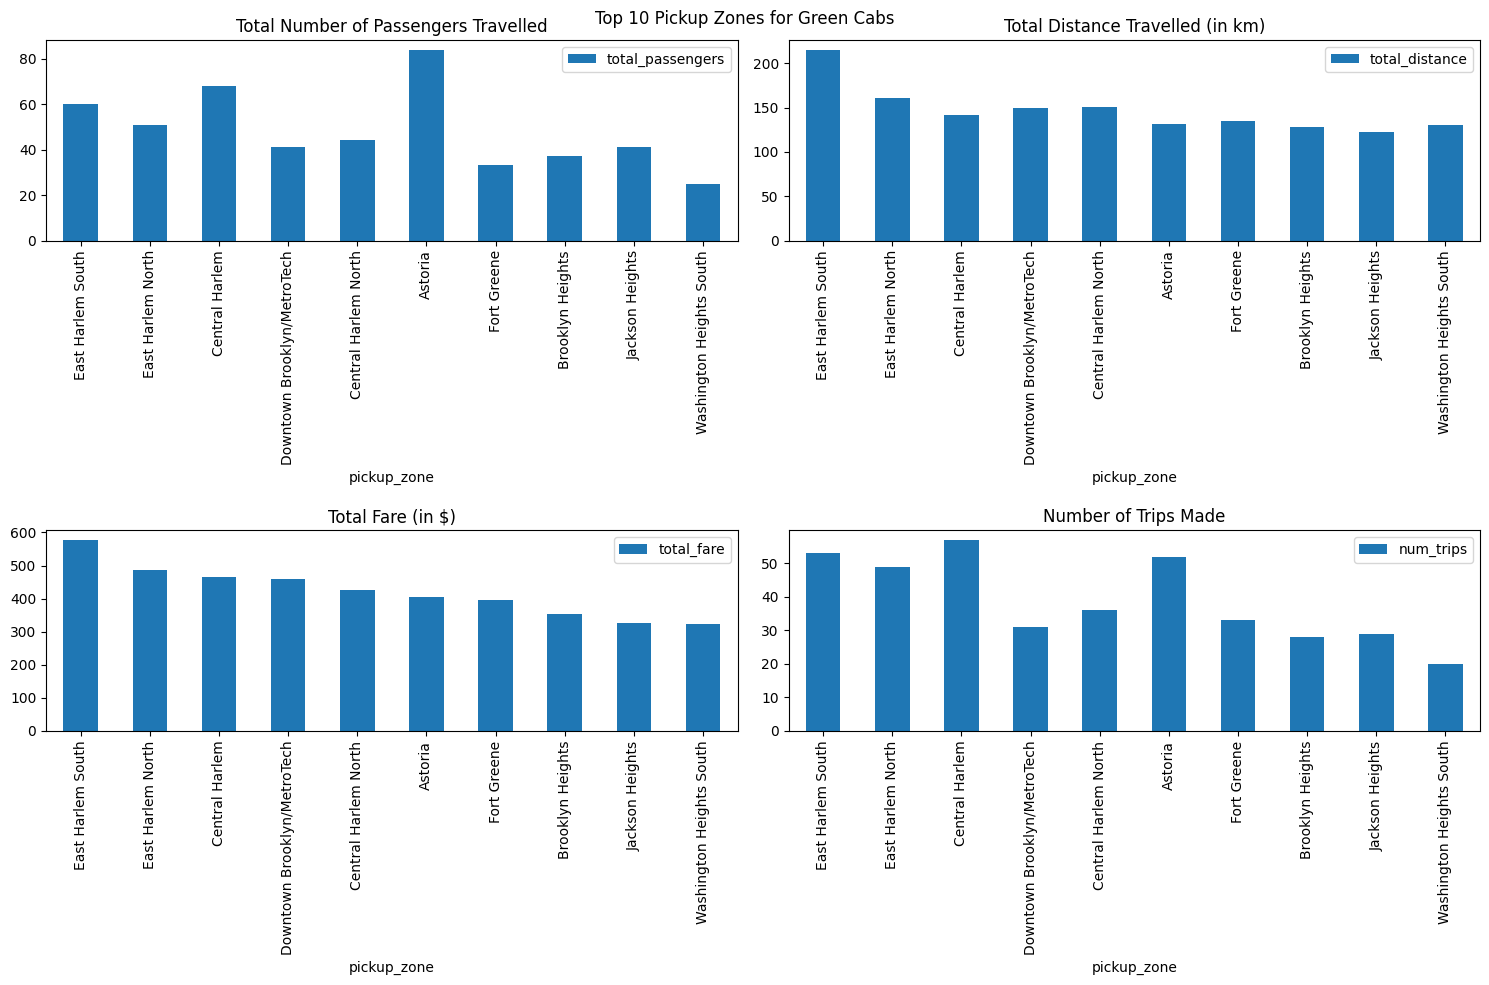

In [101]:
# Question 10b
print("Question 10b")
import matplotlib.pyplot as plt

# (After you have created your Yellow_stats_df and Green_stats_df as mentioned in the previous parts of your question...)

# Define a function to create bar charts for the specified statistics
def create_bar_charts(df, color):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Top 10 Pickup Zones for {color.capitalize()} Cabs')

    # Total number of passengers travelled
    df.plot(kind='bar', x='pickup_zone', y='total_passengers', ax=axes[0, 0])
    axes[0, 0].set_title('Total Number of Passengers Travelled')
    
    # Total distance travelled
    df.plot(kind='bar', x='pickup_zone', y='total_distance', ax=axes[0, 1])
    axes[0, 1].set_title('Total Distance Travelled (in km)')
    
    # Total fare
    df.plot(kind='bar', x='pickup_zone', y='total_fare', ax=axes[1, 0])
    axes[1, 0].set_title('Total Fare (in $)')
    
    # Number of trips made
    df.plot(kind='bar', x='pickup_zone', y='num_trips', ax=axes[1, 1]) 
    axes[1, 1].set_title('Number of Trips Made')
    
    # Adjust layout to prevent labels from overlapping
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    
    plt.show()

# Create bar charts for the top 10 pickup zones for yellow and green cabs
print("Bar Graph for Yellow Cars:")
create_bar_charts(top10_yellow_pickup_zones, 'yellow')
print("Bar Graph for Green Cars:")
create_bar_charts(top10_green_pickup_zones, 'green')


Question 10c


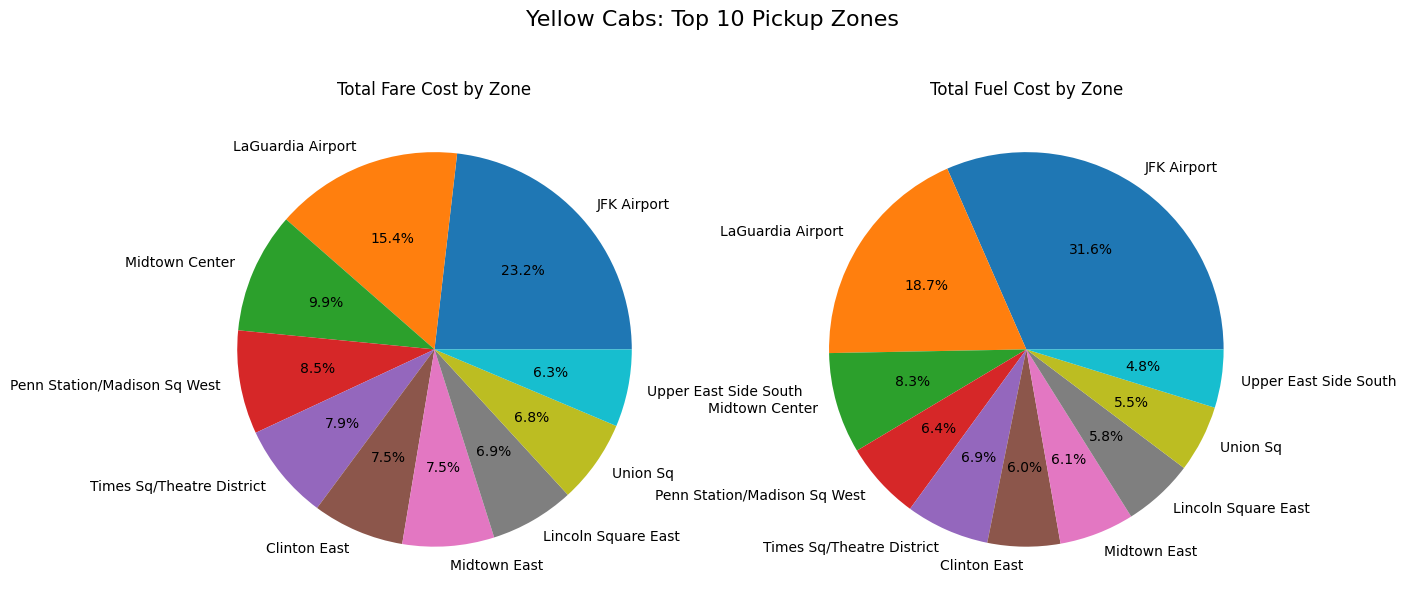

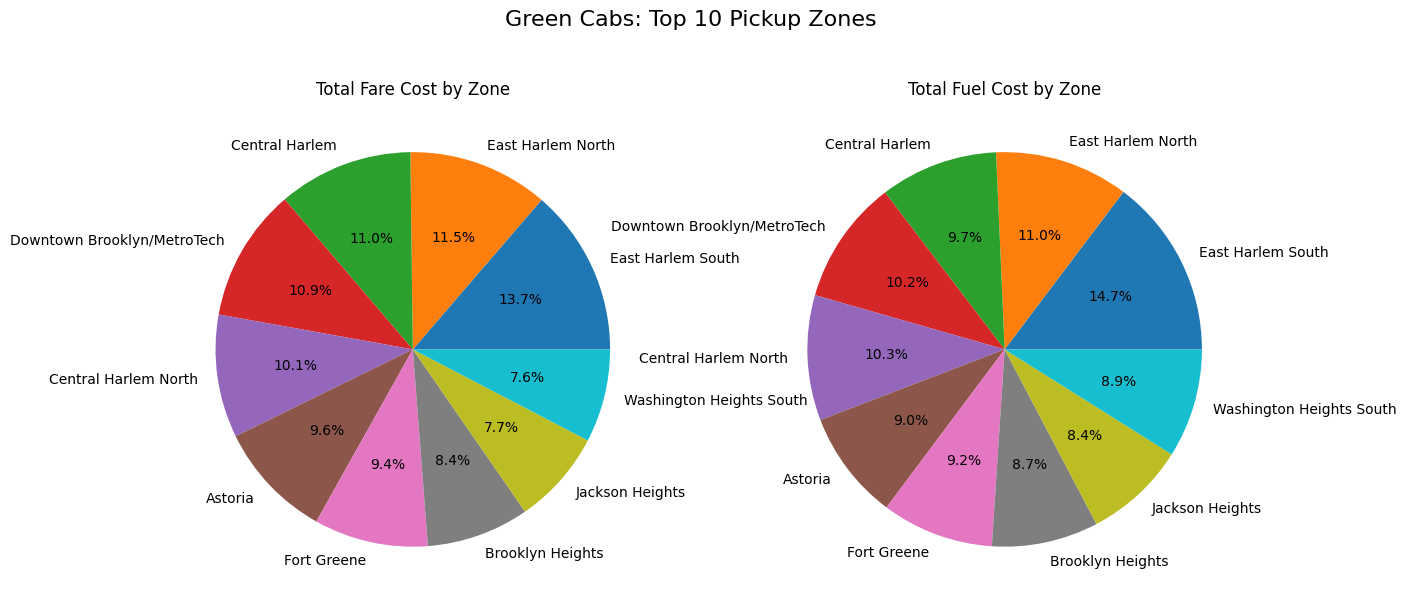

In [102]:
# Question 10c
print("Question 10c")
# Assuming that we're referring to the top 10 pickup zones (which is not explicitly stated in the question)

# Define a function to create pie charts for the specified statistics
def create_pie_charts(df, color):
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    # Pie chart for total fare cost
    df.plot(kind='pie', y='total_fare', labels=df['pickup_zone'], autopct='%1.1f%%', ax=axes[0], legend=False, fontsize=10)
    axes[0].set_ylabel('')
    axes[0].set_title('Total Fare Cost by Zone')
    
    # Pie chart for total fuel cost
    df.plot(kind='pie', y='total_fuel_cost', labels=df['pickup_zone'], autopct='%1.1f%%', ax=axes[1], legend=False, fontsize=10)
    axes[1].set_ylabel('')
    axes[1].set_title('Total Fuel Cost by Zone')

    # Set the main title for the whole figure
    fig.suptitle(f'{color.capitalize()} Cabs: Top 10 Pickup Zones', fontsize=16)
    
    # Display the pie charts
    plt.show()

# Create pie charts for the top 10 pickup zones for yellow and green cabs
create_pie_charts(top10_yellow_pickup_zones, 'yellow')
create_pie_charts(top10_green_pickup_zones, 'green')
